In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm

import cv2
import tifffile as tf


In [2]:
import py3utils as p3
import rf_utils as rfutils
import plotting as pplot
import roi_utils as rutils
import gratings_utils as gutils

In [3]:
%matplotlib notebook

# Source

In [5]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

traceid = 'traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20

# Plotting

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Aggregate meta 

In [47]:
sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,11,11,11
V1,9,9,9


In [48]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Output dir

In [49]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


#### Test 1 animal

In [50]:
va='V1'
dk='20190522_JC084_fov1'

ori_dir = gutils.get_ori_dir(dk, traceid=traceid, fit_desc=ori_fit_desc)
print(ori_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [51]:
# from class Gratings.get_tuning()
# Gets ori_fit_desc
# Loads tuning results (bootstrapped)
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)
g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)
    
# Get fits
best_fits, all_fits = gutils.get_good_fits(boot_, fitparams, 
                                                 gof_thr=None, verbose=False)
# if rmetrics is None:
#     no_fits.append('%s_%s' % (va, dk))
#     continue

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/gratings_utils.py:162: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


#### Get all animals

In [52]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, fit_desc=ori_fit_desc,
                             return_missing=True) 


In [53]:
gdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,15
Lm,10
V1,9


In [54]:
missing_

['Lm_20191111_JC120_fov1']

In [55]:
gdata = p3.split_datakey(gdata)
#gdata = gdata[~gdata.animalid.isin(old_rats)].copy()

In [56]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
        .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,datakey,animalid,fov,session
visual_area,,,,,,,,,,,,,,,,,,
Li,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261
Lm,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619
V1,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686


In [57]:
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
bestg = p3.split_datakey(bestg)
bestg = bestg[~bestg.animalid.isin(old_rats)]
bestg[bestg.visual_area=='Li']['datakey']

46     20190522_JC089_fov1
48     20190522_JC089_fov1
50     20190522_JC089_fov1
52     20190522_JC089_fov1
55     20190522_JC089_fov1
              ...         
481    20191018_JC113_fov1
482    20191018_JC113_fov1
484    20191105_JC117_fov1
488    20191105_JC117_fov1
490    20191111_JC120_fov1
Name: datakey, Length: 216, dtype: object

In [58]:
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = list(tested_thetas.copy())
theta_vals.append(360)
theta_vals = np.array(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref']]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

# Aggregate metrics

In [59]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


visual_area
Li     75
Lm    249
V1    341
Name: cell, dtype: int64


<IPython.core.display.Javascript object>


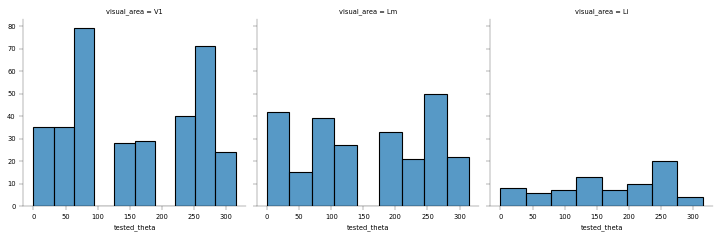

In [60]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
print(passg.groupby(['visual_area'])['cell'].count())
fg = sns.FacetGrid(passg, col='visual_area', col_order=visual_areas, height=3)
fg.map(sns.histplot, 'tested_theta')

In [63]:
gof_thr=0.25
passg = bestg[bestg['gof']>=gof_thr].copy()

<IPython.core.display.Javascript object>


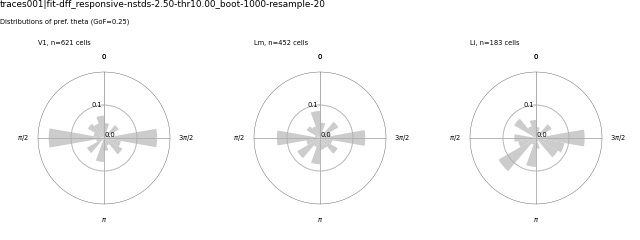

0.0 6.154957035604493
0.0 6.154957035604493
0.0 6.154957035604493
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_pref_noold_gof0.25


In [64]:
metric = 'theta_pref'
bin_size = 20
ai = 1
col='k'
fontsize=6

fig = pl.figure(figsize=(8,3))
for va, vg in passg.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    degrees = vg[metric].values
    radians = np.array([np.deg2rad(v) for v in degrees])
    print(radians.min(), radians.max())
    cmean = spstats.circmean(radians, nan_policy='omit')
    
    weights = np.ones_like(degrees)/len(degrees)
    a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                        weights=weights)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    ax.bar(centers, a, width=np.deg2rad(bin_size), 
                   bottom=0.0, color='.8', edgecolor='none')
    # Label angles according to convention
    ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'],
                      fontsize=fontsize)
    ax.set_title('%s, n=%i cells' % (va, len(vg)), loc='left', fontsize=fontsize)
    ax.set_theta_zero_location("N")
    ax.set_ylim([0, 0.2])
    ax.set_yticks(np.linspace(0, 0.1, 2))
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of pref. theta (GoF=%.2f)' % gof_thr)
p3.label_figure(fig, data_id)

figname = 'polar_%s_noold_gof%.2f' % (metric, gof_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [66]:
passg.groupby(['visual_area', 'datakey'])['cell'].count()#.groupby('visual_area').sum()

visual_area  datakey            
Li           20190522_JC089_fov1      7
             20190527_JC092_fov3      4
             20190602_JC091_fov1     50
             20190606_JC091_fov1     17
             20190607_JC091_fov1     26
             20190609_JC099_fov1      8
             20190612_JC099_fov1     15
             20190614_JC091_fov1     30
             20190617_JC099_fov1      4
             20191018_JC113_fov1     19
             20191105_JC117_fov1      2
             20191111_JC120_fov1      1
Lm           20190512_JC083_fov1     77
             20190513_JC078_fov1    172
             20190517_JC083_fov1      8
             20190525_JC084_fov1     55
             20190603_JC080_fov1     77
             20190618_JC097_fov1     26
             20190627_JC091_fov1     34
             20191105_JC117_fov1      3
V1           20190511_JC083_fov1    124
             20190512_JC083_fov1     18
             20190517_JC083_fov1      1
             20190522_JC084_fov1    102
       

# Salt N Pepper

In [67]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples


In [225]:
va='V1'
# dk='20190511_JC083_fov1'
# dk='20190616_JC097_fov1'
# dk='20190617_JC097_fov1'
dk='20190622_JC085_fov1'

# va='Li'
# # dk='20190513_JC078_fov1'
# dk= '20190607_JC091_fov1'
curr_data_id = '%s\n%s_%s' % (data_id, dk, va) #
print(curr_data_id)
zimg, masks, centroids = rutils.get_masks_and_centroids(dk)
# Check masks/centroids
# summed = masks.sum(axis=0)
# fig, ax =pl.subplots()
# ax.imshow(zimg, cmap='gray')
# ax.imshow(summed, cmap='Reds', alpha=0.5)
# sns.scatterplot(x='y', y='x', s=5, data=centroids, ax=ax)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
20190622_JC085_fov1_V1


In [226]:
sdf = p3.get_stimuli(dk, 'gratings')
tested_thetas = sorted(np.array(sdf['ori'].unique().astype(float)))
print(dk, tested_thetas)
sdf.head()

20190622_JC085_fov1 [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]


,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config007,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.5,200.0
config006,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,0.5,20.0
config005,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.5,20.0
config004,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,0.1,200.0
config003,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.1,200.0


In [227]:
len(tested_thetas)

8

In [228]:
gof_thr=0#-10000
passg = bestg[bestg['gof']>=gof_thr].copy
passg=bestg.copy()

In [229]:
sorted(df_['tested_theta'].unique())


[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

In [230]:
currg = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()
rois_ = sorted(currg['cell'].unique())
print("%i cells pass (gof=%.2f)" % (len(rois_), gof_thr))
currg.index=rois_
df_ = pd.concat([centroids.loc[rois_], currg], axis=1)
df_.shape

96 cells pass (gof=0.00)


(96, 22)

In [231]:
sorted_cells = df_.sort_values(by=['response_pref', 'gof', 'r2comb'], \
                               ascending=False)['cell'].values
sorted_cells[0:10]
plot_rois = list(sorted_cells[0:10])
print(plot_rois)

[207.0, 60.0, 260.0, 271.0, 248.0, 357.0, 351.0, 220.0, 346.0, 186.0]


In [232]:
# import sys
# # !conda install --yes --prefix {sys.prefix} skimage
# !{sys.executable} -m pip install skimage

In [233]:
# from skimage import exposure
# def adjust_grayscale_image(zimg, clip_limit=0.01):
#     '''
#     if float, image must be -1, 1 normalize
#     '''
#     im_adapthist = exposure.equalize_adapthist(zimg, clip_limit=clip_limit)
#     im_adapthist *= 256
#     im_adapthist= im_adapthist.astype('uint8')
#     #ax.imshow(im_adapthist) #pl.figure(); pl.imshow(refRGB) # cmap='gray')
#     orig = im_adapthist.copy()
#     return orig

def adjust_image_contrast(img, clip_limit=2.0, tile_size=10):#(10,10)):
    img[img<-50] = 0
    normed = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to 8-bit
    img8 = cv2.convertScaleAbs(normed)

    # Equalize hist:
    tg = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tg)
    eq = clahe.apply(img8)

    return eq


In [234]:
session, animalid, fovnum = p3.split_datakey_str(dk)
tfs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                      'gratings_run1', 'processed/processed*', 
                    'mcorrected*_deinterleaved', 'Channel01', 'File*', '*.tif'))
i_=[]
for t in tfs:
    im = tf.imread(t)
    i_.append(im)
imstack = np.dstack(i_)


<IPython.core.display.Javascript object>


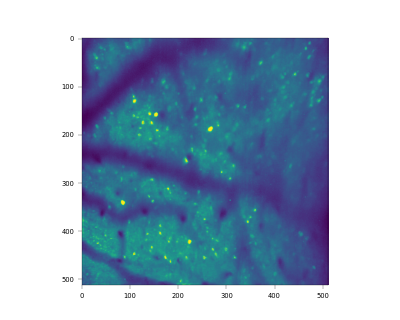

In [235]:
meanr = imstack.mean(axis=-1)
zimg_r = adjust_image_contrast(zimg, clip_limit=2.0, tile_size=5)
pl.figure()
pl.imshow(zimg_r)

<IPython.core.display.Javascript object>


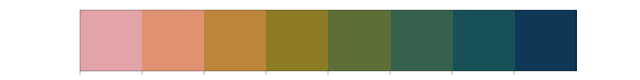

In [236]:
# colormap='cubehelix'
# cmap = mpl.cm.get_cmap(colormap, len(col_values)) # set how many colors you want in color map
colormap = 'batlow' #'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap = mpl.colors.LinearSegmentedColormap.from_list(colormap, cdata[::-1])
# modify colormap
alpha = .9
colors = []
for ind in range(cmap.N):
    c = []
    for x in cmap(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
dark_cmap = mpl.colors.ListedColormap(colors, name='dark_%s' % colormap)
mpl.cm.register_cmap("dark_%s" % colormap, dark_cmap)
# Set colors
ori_colors = sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas))
sns.palplot(sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas)))


In [238]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


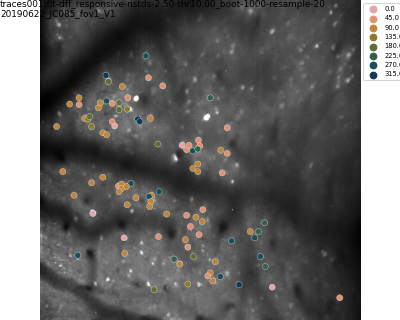

<IPython.core.display.Javascript object>


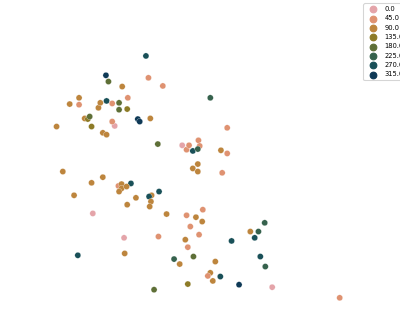

In [240]:
#highlight_rois = [27, 119, 153]
#plot_rois.extend(highlight_rois)
#plot_rois = [16, 17, 66, 91, 116, 165, 204, 215]
#plot_rois = [30, 67, 91, 163, 135, 147,215] # JC084
#plot_rois = [90, 91, 123, 142, 147, 187, 388] # JC097, 20190616
plot_rois=[]
n_actual=len(df_['tested_theta'].unique())
for label_rois in [True, False]:
    #if label_rois is False:
    fig = pl.figure(figsize=(5,4), frameon=False)
    ax = pl.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(zimg, cmap='gray', alpha=1 if label_rois else 0)
    sns.scatterplot(x='y', y='x', data=df_, ax=ax,
                    hue='tested_theta', palette=ori_colors[0:n_actual], 
                    s=30,linewidth=0.25)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.axis('off')
    if label_rois is True:
        for rid in plot_rois:
            ax.text(df_.loc[rid]['y'], df_.loc[rid]['x'], int(rid), 
                    fontsize=10, color='w')
    if label_rois:
        ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')
        pplot.label_figure(fig, curr_data_id)
    figname='saltpepper_%s_%s__nobg' % (va, dk) 
    if label_rois:
        figname='%s_labeled' % figname
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [146]:
gof_thr

0

<IPython.core.display.Javascript object>


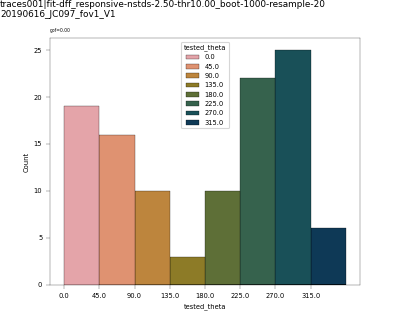

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples preftheta_histbar_V1_20190616_JC097_fov1


In [212]:
fig, ax = pl.subplots()
sns.histplot(x='tested_theta', palette=ori_colors, alpha=1, lw=0.25,
             hue='tested_theta', data=df_, ax=ax, bins=np.arange(0, 360+45, 45))
ax.set_xticks(tested_thetas) #np.arange(0, len(tested_thetas)))
ax.set_xticklabels(tested_thetas)
ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')

pplot.label_figure(fig, curr_data_id)
figname='preftheta_histbar_%s_%s' % (va, dk) 
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [213]:
np.linspace(0, 360, 9)

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

In [214]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

In [215]:
experiment='gratings'
session, animalid, fovnum = p3.split_datakey_str(dk)
print(session, animalid, fovnum)

20190616 JC097 1


In [216]:
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)

g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)

In [217]:
dff_traces, labels, sdf = p3.load_traces(animalid, session, fovnum, experiment, 
                traceid=traceid, response_type=response_type,
                responsive_test=responsive_test, responsive_thr=responsive_thr,
                n_stds=n_stds)
dff_traces.head()

,0,2,3,5,6,7,8,9,11,17,...,414,416,417,418,421,422,423,424,425,428
0,0.087446,-0.026931,0.009531,-0.011349,-0.013289,-0.008651,0.043528,-0.033252,-0.039295,-0.033315,...,-0.009405,-0.024430,-0.079511,-0.075161,-0.206267,0.072666,0.033296,-0.026728,-0.015695,-0.002383
1,-0.063194,0.026028,0.018307,0.003610,0.100756,0.023493,0.024737,0.074468,0.044709,0.049356,...,0.036992,0.059865,-0.024079,-0.003329,-0.197656,-0.061924,0.016288,0.014409,-0.152581,-0.017117
2,0.063601,0.214755,-0.014797,-0.096896,0.198353,0.111777,0.115831,-0.018391,-0.009648,-0.034978,...,0.134292,0.109488,0.062744,0.012378,-0.135539,-0.023584,-0.060620,-0.053468,0.119490,-0.007160
3,0.071537,0.140692,-0.045734,-0.085064,0.064617,0.035507,0.050131,0.058097,0.065970,-0.124790,...,0.015238,-0.029026,0.006726,0.012244,-0.232550,-0.017367,-0.016993,-0.073064,-0.045453,-0.030869
4,-0.008605,-0.034086,0.062526,0.006270,-0.172433,-0.129142,-0.092437,0.028218,0.053520,-0.143945,...,0.123295,-0.047228,0.055041,-0.034799,-0.211711,0.105088,-0.022818,-0.043410,0.187065,-0.025109


In [218]:
df_['response_pref'].max()

0.30330057426801166

In [219]:
windowsz = 9
smooth_traces = True
plot_trials = True

ymax = 0.2
min_val, max_val = 0, 0

trace_color = 'k'

transform_param = 'ori'
col_values = sorted(sdf[transform_param].unique())

In [220]:
cfg_values

[(0.1, 200.0, 10),
 (0.1, 200.0, 20),
 (0.1, 20.0, 10),
 (0.1, 20.0, 20),
 (0.5, 200.0, 10),
 (0.5, 200.0, 20),
 (0.5, 20.0, 10),
 (0.5, 20.0, 20)]

In [221]:
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]
ori_colors = sns.color_palette(palette='dark_%s' % colormap, n_colors=len(col_values))
print(col_values)
print(cfg_values)
n_conds = len(cfg_values)

[0, 45, 90, 135, 180, 225, 270, 315]
[(0.1, 20.0, 10), (0.1, 20.0, 20), (0.1, 200.0, 10), (0.1, 200.0, 20), (0.5, 20.0, 10), (0.5, 20.0, 20), (0.5, 200.0, 10), (0.5, 200.0, 20)]


In [222]:
plot_roi_list=plot_rois

<IPython.core.display.Javascript object>


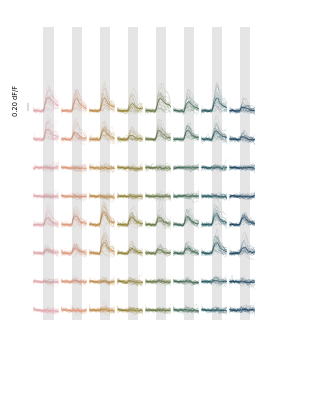

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)


In [223]:
3

<IPython.core.display.Javascript object>


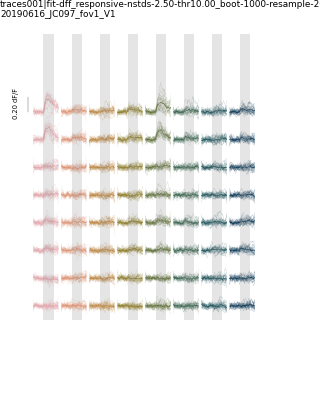

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid90


<IPython.core.display.Javascript object>


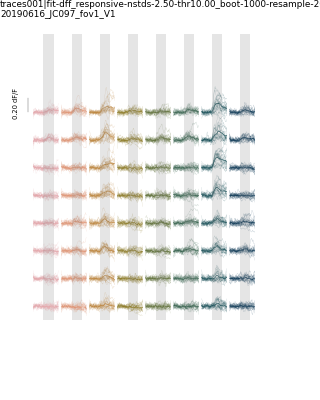

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid91


<IPython.core.display.Javascript object>


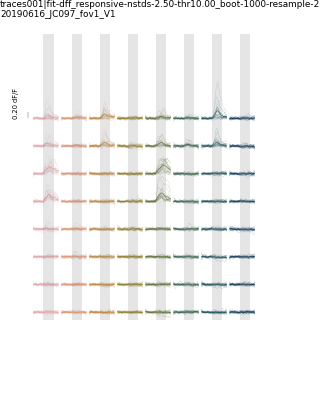

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid123


<IPython.core.display.Javascript object>


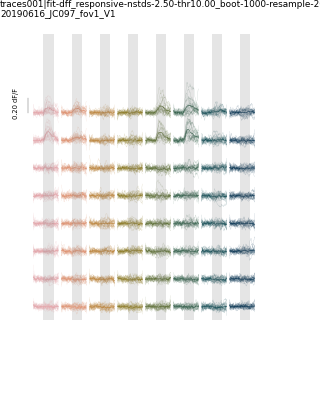

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid142


<IPython.core.display.Javascript object>


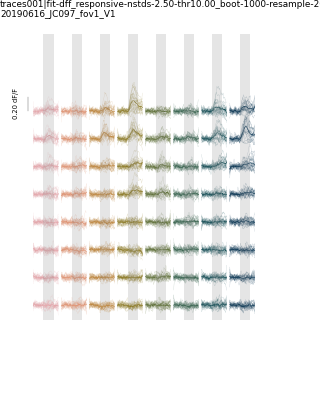

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid147


<IPython.core.display.Javascript object>


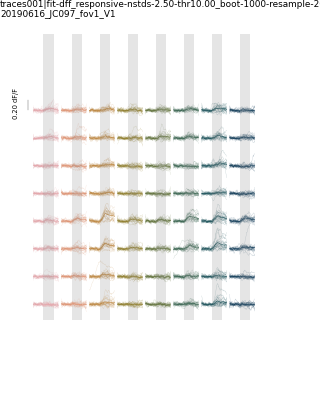

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid187


<IPython.core.display.Javascript object>


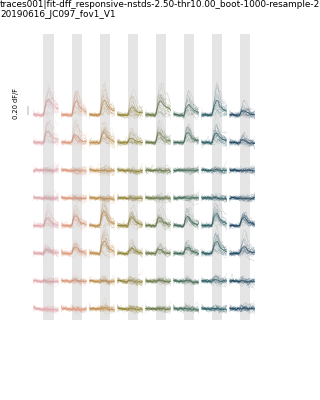

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces__V1_20190616_JC097_fov1_rid388


In [224]:
fontsize=6
n_conds = len(cfg_values)
for rid in plot_roi_list:
    fig, axes = pl.subplots(len(cfg_values), len(col_values), 
                        figsize=(4,5), sharex=False, sharey=True)
    fig.patch.set(alpha=1)
    for ci, cfgv in enumerate(cfg_values):
        condkey = cfgv #tuple([float(i) for i in cfgv.split('-')[1::2]])
        if condkey not in list(boot_[rid].keys()):
            currcfgs = sdf[(sdf['sf']==condkey[0]) 
                         & (sdf['size']==condkey[1]) & (sdf['speed']==condkey[2])].index.tolist()
        else:
            currcfgs = boot_[rid][condkey]['stimulus_configs']
        currlabels = labels[labels['config'].isin(currcfgs)]
        si = cfg_values.index(condkey)
        print(si, condkey)
        for col, (cfg, g) in zip(ori_colors, currlabels.groupby(['config'])):
            currv = sdf[transform_param][cfg] #.copy()
            plot_ix = col_values.index(currv)
            ax = axes[ci, plot_ix]
            ax.patch.set(alpha=0)
            for trial, tdf in g.groupby(['trial']):
                tsec = tdf['tsec'].values
                tvals = dff_traces[rid][tdf.index].values
                st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
                sm = temporal_downsample(tvals, windowsz) if smooth_traces else tvals
                ax.plot(st, sm, color=col, alpha=0.3, lw=0.25)
            meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
            ax.plot(tsec, sm, color=col, alpha=1, lw=0.5)

    for ai, ax in enumerate(axes.flat):
        ax.tick_params(which='both', axis='both', length=0)
        if ai == 0:
            ax.set_yticks([0, ymax])
            ax.set_yticklabels(['', ''])
            ax.set_ylabel('%.2f dF/F' % ymax, fontsize=fontsize)
            sns.despine(trim=True, ax=ax, offset=4, bottom=True)
            ax.set_xticklabels([])
        else:
            sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=True)
            ax.set_xticklabels([])
    for ci in range(len(col_values)):
        ax=axes[n_conds-1, ci]
        rect = pl.Rectangle((0,0), width=1, height=(n_conds-2)+fig.subplotpars.wspace,
                         transform=ax.get_xaxis_transform(), clip_on=False, zorder=0,
                         edgecolor="none", facecolor="gray", alpha=0.2, linewidth=0)
        ax.add_patch(rect)
    pl.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.8,hspace=-.4, wspace=0.01)

    pplot.label_figure(fig, curr_data_id)
    figname='traces__%s_%s_rid%i' % ( va, dk, rid) 
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [70]:
cfg_values


[(0.1, 200.0, 20),
 (0.1, 20.0, 20),
 (0.1, 40.0, 20),
 (0.5, 200.0, 20),
 (0.5, 20.0, 20),
 (0.5, 40.0, 20)]

In [1288]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples'

In [270]:
def calculate_signal_correlations(tuning_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate signal corrs
    corrs_ = {}
    rois_ = [i for i in tuning_.columns if p3.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for col_a, col_b in itertools.combinations(rois_, 2):
        corrs_['%i__%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], tuning_[col_b])
    sigcorrs = pd.DataFrame.from_dict(corrs_, orient='index')
    sigcorrs.columns = ['PCC', 'p-value']
    sigcorrs['cell_1'] = [int(r.split('__')[0]) for r in sigcorrs.index]
    sigcorrs['cell_2'] = [int(r.split('__')[1]) for r in sigcorrs.index]
    
    return sigcorrs

In [275]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [276]:
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

In [277]:
NDATA[NDATA.visual_area=='Li']['datakey'].unique()

array(['20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190614_JC091_fov1',
       '20190617_JC099_fov1', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype=object)

In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


### Signal corrs

In [282]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


In [283]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [284]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = p3.add_rf_positions(posdf)

Adding RF position info...


In [285]:
posdf.shape, posdf.dropna().shape

((1675, 13), (1675, 13))

In [323]:
selective_only=False
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

allcells


In [324]:
c_ = []
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = ndf['cell'].unique()
    if len(rois_)<2:
        continue
    if dk not in SD.keys():
        continue
    sdf = SD[dk].copy()
    cfgs = sdf.index.tolist()
    if len(cfgs)==0:
        continue
    ndf = ndf[(ndf.config.isin(cfgs))]
    # Reshape dataframe to ntrials x nrois
    trial_means0 = p3.stacked_neuraldf_to_unstacked(ndf)
    # Zscore trials
    cfgs_by_trial = trial_means0['config']
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) & (passg.datakey==dk)]['cell'].unique()
        if len(curr_cells)<5:
            continue
    else:
        curr_cells = rois_
    trial_means = trial_means0[curr_cells].copy()
    zscored = p3.zscore_dataframe(trial_means)
    zscored['config'] = cfgs_by_trial
    # Get mean reposnse per condition
    tuning_ = zscored.groupby(['config']).mean().reset_index()
    sigcorrs = calculate_signal_correlations(tuning_)
    # Get current FOV rfdata and add position info to sigcorrs df
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[sigcorrs['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[sigcorrs['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    sigcorrs['cortical_distance'] = dists
    sigcorrs['visual_area'] = va
    sigcorrs['datakey'] = dk
    c_.append(sigcorrs)
signal_corrs = pd.concat(c_, axis=0).reset_index(drop=True)


In [325]:
# Bin cortical distances for plotting
n_bins_dist = 10
n_bins_overlap = 8
use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    signal_corrs['binned_dist'], bin_edges = pd.qcut(signal_corrs['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    signal_corrs['binned_dist'], bin_edges = pd.cut(signal_corrs['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False

binning: eqwidth10


In [326]:
min_n_pairs=10
counts_per_bin = signal_corrs.groupby(['visual_area', 'datakey', 'binned_dist'])\
                    ['PCC'].count().reset_index()
pass_keys = [(va, dk) for (va, dk), g in \
             counts_per_bin[counts_per_bin['PCC']>=min_n_pairs].groupby(['visual_area', 'datakey'])]
CC = pd.concat([g for (va, dk), g in signal_corrs.groupby(['visual_area', 'datakey']) \
               if (va, dk) in pass_keys])
CC.shape, signal_corrs.shape

((90940, 8), (90995, 8))

In [327]:
mean_ccs = CC.groupby(['visual_area', 'datakey', 'binned_dist']).mean().reset_index()

<IPython.core.display.Javascript object>


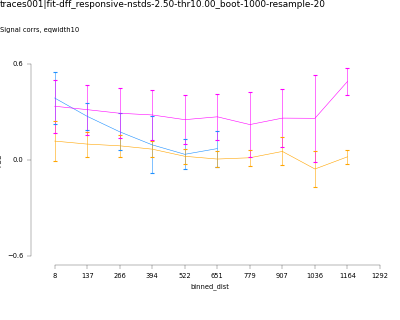

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics sigcorrs_by_dist__allstim_allcells


In [329]:
lw=0.5
metric='PCC'
fig, ax = pl.subplots( figsize=(5,4)) #, sharex=True, sharey=False)
sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, 
             ci='sd', err_style='bars', 
            err_kws={'capsize':2, 'lw': lw}, lw=lw)
ax.set_xticks(list(range(len(bin_edges))))
ax.set_xticklabels([round(i) for i in bin_edges])
ax.set_ylim([-0.6, 0.6])
ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])

sns.despine(offset=8, trim=True, ax=ax)
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal corrs, %s' % bin_type)
figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## ASI/DSI

In [342]:
def combine_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='asi']
    sd1 = scatdf[all_cols].copy().rename(columns={'dsi': 'value'})
    sd1['ori_metric'] = 'dsi'

    all_cols = [k for k in scatdf.columns if k!='dsi']
    sd2 = scatdf[all_cols].copy().rename(columns={'asi': 'value'})
    sd2['ori_metric'] = 'asi'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd

In [331]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
combog = combine_metrics(passg)


<IPython.core.display.Javascript object>


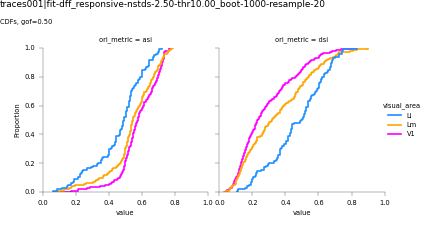

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [332]:
fg = sns.displot(combog, col='ori_metric', col_order=['asi', 'dsi'],
            x='value', hue='visual_area', palette=area_colors, height=3,
           kind='ecdf', aspect=0.8)
for ax in fg.axes.flat:
    ax.set_xlim([0, 1])
fg.fig.text(0.0, 0.9, 'CDFs, gof=%.2f' % gof_thr)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'ASI_DSI_gof%.2f_cdf' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

In [333]:
gof_thr

0.5

In [338]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

In [348]:
combog = combine_metrics(passg)
curr_counts = combog.groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
finaldf = pd.concat([g for (va, dk), g in combog.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

<IPython.core.display.Javascript object>


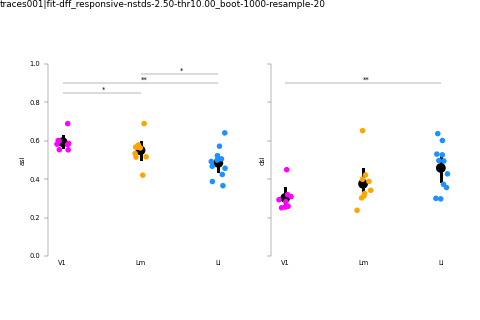

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.030301   16.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li    True  0.030301   24.0   9  11
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.069145   18.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li   False  0.085730   31.0   9  11
****************************


In [349]:
meang = finaldf.groupby(['visual_area', 'datakey', 'ori_metric']).mean().reset_index()
# fg = sns.FacetGrid(meang, col='ori_metric', col_order=['asi', 'dsi'], 
#               height=3)

# fg.map(sns.stripplot,'visual_area', 'value', 'visual_area', 
#        palette=area_colors)
# fg.map(sns.pointplot,'visual_area', 'value', join=False, color='k')

multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, meang.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,
                 palette=area_colors, hue='visual_area', order=visual_areas)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

# fig.text(0, 0.9, 'ASI & DSI, Means by FOV (gof=%.2f, mc=%s)' % (gof_thr, multi_comp_test))
# figname = 'ASI_DSI_gof%.2f_byFOV' % gof_thr
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, gof_thr)

## Counts

In [354]:
gdata[gdata.visual_area=='Li']

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,visual_area,datakey,animalid,fov,session
0,0.528705,0.524802,0.025275,-0.010931,0.038352,52.129545,0.000000,0.727584,160.0,0.365496,0.376922,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
1,0.341041,0.685649,0.020652,-0.017558,0.059309,53.811532,132.244898,0.793545,170.0,0.323455,0.397306,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
2,0.590751,0.679958,0.009313,-0.001160,0.027233,39.562740,352.653061,0.892822,172.0,0.899031,0.765403,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
3,0.241354,0.572965,0.024139,-0.021777,0.047835,69.826945,227.755102,0.671892,177.0,0.660583,0.458513,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
4,0.407956,0.362389,0.017694,-0.012919,0.037090,70.338493,80.816327,0.603767,178.0,0.327887,0.230345,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0.527400,0.642588,0.012131,-0.000475,0.025826,49.363570,337.959184,0.545497,20.0,0.179227,0.160924,0.5,200.0,20.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
487,0.607651,0.489988,0.009905,0.001922,0.022655,35.299134,308.571429,0.566529,20.0,0.209501,0.201317,0.1,200.0,20.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
488,0.543529,0.612775,0.012180,-0.003092,0.033279,43.136791,132.244898,0.751625,20.0,0.462130,0.431036,0.1,200.0,10.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
489,0.513413,0.276885,0.110679,-0.047936,0.146132,48.301936,286.530612,0.819210,13.0,0.733408,0.587329,0.1,40.0,20.0,Li,20191111_JC120_fov1,JC120,FOV1_zoom2p0x,20191111


In [355]:
responsive_ = gdata.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
responsive_.shape

(34, 3)

In [356]:
tuned_ = bestg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
tuned_.shape

(34, 3)

In [359]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

pass_ = passg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
pass_.shape

(33, 3)

In [360]:
# d_=[]
# for selector, t in zip(['visual', 'fit', 'gof'], [responsive_, tuned_, pass_]):
#     x = t.copy().rename(columns={'cell': selector}).reset_index(drop=True)
#     d_.append(x)
    
responsive0 = responsive_.copy()\
                .rename(columns={'cell': 'visual'}).reset_index(drop=True)

pass0 = pass_.copy()\
                .rename(columns={'cell': 'gof'}).reset_index(drop=True)
responsive0.head()

,visual_area,datakey,visual
0,Li,20190314_JC070_fov1,31
1,Li,20190315_JC070_fov2,6
2,Li,20190319_JC067_fov1,8
3,Li,20190522_JC089_fov1,15
4,Li,20190527_JC092_fov3,7


In [361]:
pass0[(pass0.visual_area==va) & (pass0.datakey==dk)]

,visual_area,datakey,gof
32,V1,20191006_JC110_fov1,21


In [364]:
counts = responsive0.copy()
for (va, dk), g in counts.groupby(['visual_area', 'datakey']):
    pg = pass0[(pass0.visual_area==va) & (pass0.datakey==dk)].copy()
    if len(pg)==0:
        ncells = 0
    else:
        ncells = float(pg['gof'])
    counts.loc[g.index, 'gof'] = ncells
# counts['gof'] = pass0['gof'].values

In [365]:
# counts = pd.merge(responsive0, pass0, left_index=True, right_index=True, how='left')
# print(counts.shape)
# counts.head()

In [366]:
import copy

In [367]:
min_ncells=10

In [368]:
counts['gof_over_visual'] = counts['gof']/counts['visual'].astype(float)

In [369]:
excl = copy.copy(old_rats) #['20190314_JC070_fov1', '20190306_JC061_fov2', '20190314_JC070_fov2']
currd =counts[(counts['visual']>=min_ncells) & ~(counts.datakey.isin(excl))].copy()
currd[currd.visual_area=='Lm']

,visual_area,datakey,visual,gof,gof_over_visual
15,Lm,20190306_JC061_fov2,66,31.0,0.469697
16,Lm,20190314_JC070_fov2,48,13.0,0.270833
17,Lm,20190512_JC083_fov1,166,10.0,0.060241
18,Lm,20190513_JC078_fov1,531,121.0,0.227872
19,Lm,20190517_JC083_fov1,20,5.0,0.250000
20,Lm,20190525_JC084_fov1,121,33.0,0.272727
21,Lm,20190603_JC080_fov1,171,44.0,0.257310
22,Lm,20190618_JC097_fov1,62,14.0,0.225806
23,Lm,20190627_JC091_fov1,77,20.0,0.259740


In [370]:
currd

,visual_area,datakey,visual,gof,gof_over_visual
0,Li,20190314_JC070_fov1,31,16.0,0.516129
3,Li,20190522_JC089_fov1,15,5.0,0.333333
5,Li,20190602_JC091_fov1,138,20.0,0.144928
6,Li,20190606_JC091_fov1,29,6.0,0.206897
7,Li,20190607_JC091_fov1,67,12.0,0.179104
8,Li,20190609_JC099_fov1,14,4.0,0.285714
9,Li,20190612_JC099_fov1,42,5.0,0.119048
10,Li,20190614_JC091_fov1,79,12.0,0.151899
11,Li,20190617_JC099_fov1,11,3.0,0.272727
12,Li,20191018_JC113_fov1,36,6.0,0.166667


<IPython.core.display.Javascript object>


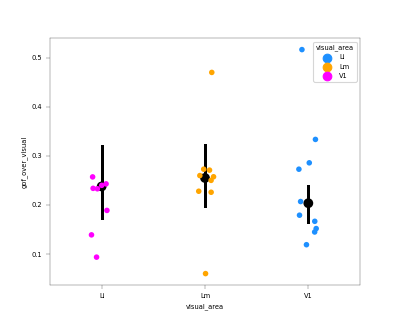

********* [gof_over_visual] Mann-Whitney U test(mc=holm) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.168527   19.0   8   9
1  V1  Li   False  0.624054   36.0   8  10
2  Lm  Li   False  0.624054   38.5   9  10
****************************


(   d1  d2  reject     p_val  U_val  n1  n2
 0  V1  Lm   False  0.168527   19.0   8   9
 1  V1  Li   False  0.624054   36.0   8  10
 2  Lm  Li   False  0.624054   38.5   9  10,
 <AxesSubplot:xlabel='visual_area', ylabel='gof_over_visual'>)

In [371]:

fig, ax = pl.subplots()
#sns.barplot(x='visual_area', y='fraction_gof_over_visual', data=currd, ax=ax)
sns.stripplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax,
             order=visual_areas, hue='visual_area', palette=area_colors)
sns.pointplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax, 
              join=False,  color='k')
pplot.plot_mannwhitney(currd, metric='gof_over_visual', 
            multi_comp_test='holm',
    ax=ax,
    y_loc=0.95,
    offset=0.1,
    lw=0.25,
    fontsize=6)

In [373]:
# Load RF data
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = p3.add_rf_positions(rfdata)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
Adding RF position info...


In [374]:
combined_rfs = rfutils.average_rfs_select(rfdata)
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
rfdf = pd.concat(df_)


In [483]:
gd =gdata[~gdata['animalid'].isin(old_rats)].copy()
GFS[GFS['visual_area']=='V1'].shape, GFS[GFS['visual_area']=='V1'].dropna().shape

((710, 19), (710, 19))

In [484]:
DF[DF['visual_area']=='V1'].shape, DF[DF['visual_area']=='V1'].dropna().shape

((710, 48), (40, 48))

In [501]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
DF.dropna().groupby(['visual_area']).count()

Li: 0 cells in common (20190522_JC089_fov1)
Li: 5 cells in common (20190527_JC092_fov3)
Li: 35 cells in common (20190602_JC091_fov1)
Li: 6 cells in common (20190606_JC091_fov1)
Li: 9 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 3 cells in common (20190612_JC099_fov1)
Li: 14 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 4 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191105_JC117_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 25 cells in common (20190512_JC083_fov1)
Lm: 19 cells in common (20190513_JC078_fov1)
Lm: 4 cells in common (20190517_JC083_fov1)
Lm: 23 cells in common (20190525_JC084_fov1)
Lm: 27 cells in common (20190603_JC080_fov1)
Lm: 3 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 41 cells in common (20190511_JC083_fov1)
V1: 5 cells in common (20190512_JC083_fov1)
V1: 1 cells in common (20190517_JC083_fov1)
V1: 80 cells in common (2

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Lm,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
V1,290,290,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290


In [502]:
counts_by_fov = DF[DF['gof']>=0.5].dropna().groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov = p3.split_datakey(counts_by_fov)

In [503]:
overall_best = p3.select_best_fovs(counts_by_fov)
overall_best.groupby(['visual_area']).sum()
overall_dkeys = list(tuple(k) for k in overall_best[['visual_area', 'datakey']].values)

finaldf = pd.concat([g for (va,dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in overall_dkeys])

In [504]:
finaldf.dropna().groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
Lm,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
V1,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289


In [505]:
finaldf[finaldf['gof']>=0.].groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
Lm,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
V1,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289


In [506]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


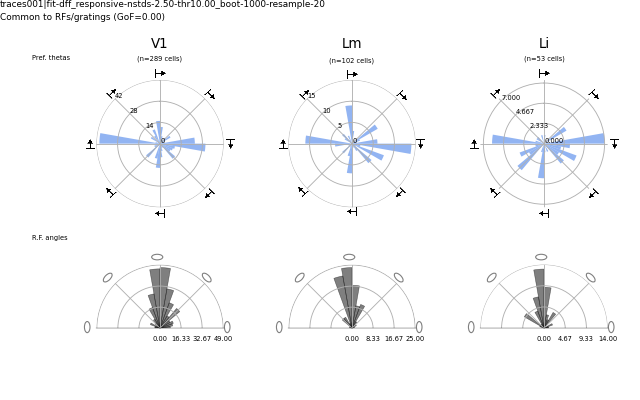

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_v_RFangles__gof0.00


In [568]:
gof_thr=0.0

plotd = finaldf[finaldf['gof']>=gof_thr].copy().dropna()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5

bar_width=10.
bin_size = 10

max_ori = 360.
ori_bins = np.arange(0, max_ori+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    # --------------------------------------------------------------------
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    # ---------------------------------------------------------------------
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

figname = 'polar_theta_v_RFangles__gof%.2f' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [569]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [570]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [571]:
DF.groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Lm,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
V1,290,290,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290


In [572]:
curr_vs.columns

Index(['asi', 'dsi', 'response_null', 'response_offset', 'response_pref',
       'sigma', 'theta_pref', 'r2', 'cell', 'r2comb', 'gof', 'sf', 'size',
       'speed', 'visual_area', 'datakey', 'animalid', 'fov', 'session',
       'tested_theta', 'aniso_index', 'anisotropy', 'ap_pos', 'area',
       'experiment', 'fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix',
       'fovnum', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fx', 'fy', 'major_axis',
       'minor_axis', 'ml_pos', 'ratio_xy', 'std_avg', 'std_x', 'std_y',
       'theta', 'theta_Mm_c', 'theta_Mm_deg', 'theta_c', 'x0', 'y0',
       'theta_deg'],
      dtype='object')

In [579]:
rf_color='k'
ori_color='cornflowerblue'

plotd = DF.dropna().copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 10 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, color=ori_color,
                    kde=True, stat='count', lw=0, binrange=(0, 360))
#                     discrete=True) #$, ax=ax)
        #cnts, edges = np.histogram(pref_theta_deg, bins=8)
        #bwidth = np.mean(np.diff(edges))/2.
        #most_thetas = edges[cnts.argmax()] +bwidth
        #ax.plot(most_thetas, 0, color='r', marker='^')
        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.5)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
figname = 'hist_RFangle_vs_preferredtheta'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

print(dstdir, figname)

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

Li:: 78 cells


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Lm:: 106 cells
V1:: 290 cells


NameError: name 'dstdir' is not defined

In [574]:
curr_vs['tested_theta']

195    135.0
208    270.0
210    270.0
218    270.0
223    135.0
226     90.0
227     90.0
236      0.0
240    225.0
242    180.0
244     45.0
261    180.0
262     90.0
264      0.0
273    180.0
274    270.0
278    180.0
282     90.0
285    270.0
313    270.0
314    225.0
315    270.0
322    180.0
327    225.0
331    270.0
334    180.0
340    180.0
348     90.0
376    270.0
386    270.0
393      0.0
399      0.0
401      0.0
415    225.0
429    270.0
466    225.0
Name: tested_theta, dtype: float64

In [535]:
cnts, edges = np.histogram(pref_theta_deg, bins=20)
edges[cnts.argmax()+1]

array([ 3,  1,  0,  0,  3,  2,  0,  1,  1,  1,  4,  3,  2,  2,  1, 10,  0,
        0,  0,  2])

In [536]:
edges[cnts.argmax()+1]

276.2448979591837

In [526]:
centers[cnts.argmax()]

337.0

In [528]:
centers

array([ 22.,  67., 112., 157., 202., 247., 292., 337.])

In [ ]:
pass_['filter'] = 'gof'
tuned_['filter'] = 'fit'
responsive_['filter'] = 'visual'

In [ ]:
counts = pd.concat([responsive_, tuned_, pass_], axis=)
counts.head()

In [ ]:

# Add 'tuned' cellss
updated_counts = add_tuned_cells(responsive_cells, gdata, metric='r2comb', responsive_thr=0.5)
updated_counts.groupby(['visual_area']).sum()